# a notebook to figure out some plotting stuff
- for example, a strikezone view of the pitches when they cross the plate
- 3d trails if I can figure that out ( I think there are polynomials in the baseball savant endpoint here: https://baseballsavant.mlb.com/gf?game_pk=) 

In [11]:
from pybaseball import statcast
from pybaseball import playerid_reverse_lookup
from pybaseball import statcast_batter, spraychart, plot_stadium

import requests as re
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

from matplotlib.animation import FuncAnimation, PillowWriter

from src.baseball import *


In [ ]:
pd.read_csv("data/tto.csv")

In [37]:
# this defaults to yesterday
end_dt = '2023-04-05'
# remember this will be utc 
#end_dt = str(datetime.date.today() + datetime.timedelta(days=-1))

df = statcast(start_dt=end_dt, end_dt=end_dt)

print(df.shape)

This is a large query, it may take a moment to complete


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.79s/it]

(3520, 92)


In [3]:
df.head(20)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
1835,SL,2023-04-05,78.2,-3.27,4.05,"Thompson, Ryan",657041,657044,field_out,hit_into_play,...,7,7,2,2,7,Standard,Standard,77,-0.004,-0.349
1896,SI,2023-04-05,92.3,-3.51,4.18,"Thompson, Ryan",657041,657044,NaN,foul,...,7,7,2,2,7,Standard,Standard,268,0.0,-0.127
1925,SI,2023-04-05,92.0,-3.35,4.08,"Thompson, Ryan",657041,657044,NaN,called_strike,...,7,7,2,2,7,Standard,Standard,266,0.0,-0.123
1979,SL,2023-04-05,79.2,-3.47,4.03,"Thompson, Ryan",657041,657044,NaN,ball,...,7,7,2,2,7,Standard,Standard,73,0.0,0.103
2012,SI,2023-04-05,91.8,-3.43,4.05,"Thompson, Ryan",682928,657044,field_out,hit_into_play,...,7,7,2,2,7,Standard,Standard,270,-0.011,-0.463
2073,SL,2023-04-05,78.8,-3.42,4.03,"Thompson, Ryan",682928,657044,NaN,ball,...,7,7,2,2,7,Standard,Standard,81,0.0,0.027
2133,SL,2023-04-05,78.8,-3.56,4.0,"Thompson, Ryan",682928,657044,NaN,swinging_strike,...,7,7,2,2,7,Standard,Standard,80,0.0,0.012
2224,SI,2023-04-05,90.2,-3.44,4.03,"Thompson, Ryan",645302,657044,walk,ball,...,7,7,2,2,7,Standard,Standard,264,0.009,0.337
2237,SI,2023-04-05,89.9,-3.45,3.95,"Thompson, Ryan",645302,657044,NaN,foul,...,7,7,2,2,7,Standard,Standard,276,0.0,0.0
2342,SI,2023-04-05,90.2,-3.55,4.01,"Thompson, Ryan",645302,657044,NaN,called_strike,...,7,7,2,2,7,Standard,Standard,267,0.0,-0.204


In [ ]:
df.pitcher.value_counts()

In [ ]:
a_pitch = df.loc[1]

In [ ]:
a_pitch

In [ ]:
a_pitch.game_pk

In [ ]:
pitch_abbreviation_to_name = {
    "FF" : "4-Seam Fastball",
    "CU" : "Curveball",
    "CH" : "Changeup",
    "FC" : "Cutter",
    "EP" : "Eephus",
    "FO" : "Forkball",
    "KN" : "Knuckleball",
    "KC" : "Knuckle-curve",
    "SC" : "Screwball",
    "SI" : "Sinker",
    "SL" : "Slider",
    "FS" : "Splitter",
    "FT" : "2-Seam Fastball",
    "ST" : "Sweeper",
    "SV" : "Slurve"
}

In [ ]:
# Do this again, but for all pitches

all_pitches = df[df.pitcher == 664285]
# here is the game that he pitched in https://www.youtube.com/watch?v=r5-DFUnWevY

In [ ]:
all_pitches.pitch_type.value_counts()

In [ ]:
all_pitches.columns

## Quick things to make this better
- turn into a function
- different colors for different pitch types
- draw a plate?
- markers that show speed and type
- maybe movement with like a empty circle, vector, filled circle


maybe make it infer which kind of plot to make?

In [86]:
def plot_strike_zone(pitch_df: pd.DataFrame, title: str = '', colorby: str = 'pitch_type', annotation: str = None, axis = None, animated: bool = False, i = None) -> None:
    """
    Produces a pitches overlaid on a strike zone using statcast data
    
    Args:
        pitch_df: (pandas.DataFrame)
            StatCast pandas.DataFrame of StatCast batter data
        title: (str), default = ''
            Optional: Title of plot
        colorby: (str), default = 'pitch_type'
            Optional: Which category to color the mark with. 'pitch_type','pitcher', 'description' or a column within data
        legend_title: (str), default = based on colorby
            Optional: Title for the legend
        width: (int), default = 500
            Optional: Width of plot (not counting the legend)
        height: (int), default = 500
            Optional: Height of plot
    Returns:
        A matplotlib.axes.Axes object that was used to generate the pitches overlaid on the strike zone
    """
    
    
    # some things to auto adjust formatting
    # make the markers really visible when fewer pitches
    alpha_markers = min(0.8, 0.5 + 1 / pitch_df.shape[0])
    alpha_text = alpha_markers + 0.2
    
    if animated:
        pitch_df = pitch_df.iloc[:i]
        
    
    # define Matplotlib figure and axis
    if axis is None:
        fig, axis = plt.subplots()

    # add home plate to plot 
    home_plate_coords = [[-0.71, 0], [-0.85, -0.5], [0, -1], [0.85, -0.5], [0.71, 0]]
    plate = Polygon(home_plate_coords,
                edgecolor = 'darkgray',
                facecolor = 'lightgray',
                lw = 2)
    axis.add_patch(plate)
    
    # add strike zone to plot. technically this can vary by batter
    # ignore that for now
    axis.add_patch(Rectangle((-0.71, 1.5), 2*0.71, 2,
                 edgecolor = 'lightgray',
                 fill=False,
                 lw=3))
    
    legend_title = ""
    color_label = ""
    
    # to avoid the SettingWithCopyWarning error
    sub_data = pitch_df.copy().reset_index(drop=True)
    
    if colorby == 'pitch_type':
        color_label = 'pitch_type'
        
        if not legend_title:
            legend_title = 'Pitch Type'
            
    elif colorby == 'description':
        values = sub_data.loc[:, 'description'].str.replace('_', ' ').str.title()
        sub_data.loc[:, 'desc'] = values
        color_label = 'desc'
        
        if not legend_title:
            legend_title = 'Pitch Description'
    elif colorby == 'pitcher':
        color_label = 'player_name'
        
        if not legend_title:
            legend_title = 'Pitcher'
            
    elif colorby == "events":
        # only things where something happened
        sub_data = sub_data[sub_data['events'].notna()]
        sub_data['event'] = sub_data['events'].str.replace('_', ' ').str.title()
        color_label = 'event'
        
        if not legend_title:
            legend_title = 'Outcome'
    
    else:
        color_label = colorby
        if not legend_title:
            legend_title = colorby
        
    scatters = []
    
    for color in sub_data[color_label].unique():
        color_sub_data = sub_data[sub_data[color_label] == color]
        scatters.append(axis.scatter(
            color_sub_data["plate_x"],
            color_sub_data['plate_z'],
            s = 10**2,
            label = pitch_abbreviation_to_name[color] if color_label == 'pitch_type' else color,
            alpha = alpha_markers
        ))

        
        # add an annotation at the center of the marker
        if annotation:
            for j, pitch_coord in zip(color_sub_data.index, zip(color_sub_data["plate_x"], color_sub_data['plate_z'])):
                label_formatted = color_sub_data.loc[j, annotation]
                label_formatted = label_formatted if not pd.isna(label_formatted) else ""
                
                if annotation in ["release_speed", "effective_speed", "launch_speed"] and label_formatted != "":
                    label_formatted = "{:.0f}".format(label_formatted)
                
                axis.annotate(label_formatted,
                            pitch_coord,
                            size = 7,
                            ha = 'center',
                            va = 'center',
                            alpha = alpha_text)

    axis.set_xlim(-4, 4)
    axis.set_ylim(-1.5, 7)
    
    axis.axis('off')

    axis.legend(handles=scatters, title=legend_title, bbox_to_anchor=(1.1, 1), loc='upper right', fontsize="8")
    plt.title(title)

    #plt.show()
    
    #return ax
    
    

In [ ]:
all_pitches = df[df["pitcher"] == 664285]

plot_strike_zone(all_pitches, colorby = 'description', annotation = "pitch_type")

In [ ]:
plot_strike_zone(df.iloc[:20], colorby = 'events', annotation = "launch_speed")

In [ ]:
plot_strike_zone(df.iloc[:20], colorby = 'events', annotation = "pitch_type")

In [ ]:
plot_strike_zone(all_pitches.iloc[:10], title = "This is a title", colorby = 'description', annotation = "pitch_type")

In [ ]:
plot_strike_zone(all_pitches.iloc[:20], colorby = 'description', annotation = "release_speed")

In [ ]:
plot_strike_zone(all_pitches, colorby = 'pitch_type', annotation = "release_speed")

In [ ]:
plot_strike_zone(all_pitches.iloc[:20], colorby = 'pitcher', annotation = "release_speed")

In [ ]:
plot_strike_zone(df.iloc[:50], colorby = 'pitcher', annotation = "release_speed")

In [ ]:
plot_strike_zone(df.iloc[:50], colorby = 'pitcher', annotation = "launch_speed")

## figure out how to put this side by side

In [ ]:
# I think I need to add an optional axis argument in the spraychart fucntion so I can pass in as a subgraph

# how to preserve the aspect ratio?
# I think this is what I need
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/mosaic.html

In [ ]:
def spraychart1(data: pd.DataFrame, team_stadium: str, title: str = '', tooltips = None,  # pylint: disable=too-many-arguments
               size: int = 100, colorby: str = 'events', legend_title: str = '', width: int = 500,
               height: int = 500, axis = None):
    """
    Produces a spraychart using statcast data overlayed on specified stadium
    
    Args:
        data: (pandas.DataFrame)
            StatCast pandas.DataFrame of StatCast batter data
        team_stadium: (str)
            Team whose stadium the hits will be overlaid on
        title: (str), default = ''
            Optional: Title of plot
        tooltips: (List[str]), default = None
            Optional: List of variables in data to include as tooltips (Deprecated)
        size: (int), default = 100
            Optional: Size of hit circles on plot
        colorby: (str), default = 'events'
            Optional: Which category to color the mark with. 'events','player', or a column within data
        legend_title: (str), default = based on colorby
            Optional: Title for the legend
        width: (int), default = 500
            Optional: Width of plot (not counting the legend)
        height: (int), default = 500
            Optional: Height of plot
    Returns:
        A matplotlib.axes.Axes object that was used to generate the stadium render and the spraychart
    """
    
    plt.axis("off")


    # pull stadium plot to overlay hits on
    base = plot_stadium(team_stadium, title, width-50, height, axis=axis)

    # only plot pitches where something happened
    sub_data = data.copy().reset_index(drop=True)
    sub_data = sub_data[sub_data['events'].notna()][sub_data['hc_x'].notna()][sub_data['hc_y'].notna()]
    if colorby == 'events':
        sub_data['event'] = sub_data['events'].str.replace('_', ' ').str.title()
        color_label = 'event'
        if not legend_title:
            legend_title = 'Outcome'
    elif colorby == 'player':
        color_label = 'player_name'
        if not legend_title:
            legend_title = 'Player'
    else:
        color_label = colorby
        if not legend_title:
            legend_title = colorby

    # scatter plot of hits
    scatters = []
    for color in sub_data[color_label].unique():
        color_sub_data = sub_data[sub_data[color_label] == color]
        scatters.append(base.scatter(
            color_sub_data["hc_x"], color_sub_data['hc_y'].mul(-1), size, label=color, alpha=0.5
        ))

    if tooltips:
        warnings.warn(
            "Tooltips are disabled in the pyplot version of spraychart and will be removed in the future",
            category=DeprecationWarning
        )

    plt.legend(handles=scatters, title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')


    
    #plt.draw()

    #plt.show()

    #return base

In [ ]:
spray_ax = spraychart(df.iloc[:50], "orioles", height = 400, width=400)

### Make a wrapper for the headshot getter

In [ ]:
def get_player_headshot(mlbam_id, size = 200, file_path = "data/headshots/", file_name = None):
    
    base_img_url = "https://img.mlbstatic.com/mlb-photos/image/upload/w_{size},q_200/v1/people/{mlbam_id}/headshot/silo/current".format(size = size, mlbam_id = mlbam_id)
    
    print(base_img_url)
    
    img_resp = re.get(base_img_url)
    
    if img_resp.status_code != 200:
        print(img_resp.status_code)
        
        return -1
    else:
        os.makedirs(file_path, exist_ok=True)
        
        if file_name is None:
            file_name = str(mlbam_id) + ".png"
            
            
        with open(file_path + file_name, 'wb') as f:
            f.write(img_resp.content)
    

In [ ]:
get_player_headshot(664284)

### Make a visualization with the strikezone

In [ ]:
# THIS WILL ONLY WORK FOR THE FIRST PERSON! 

def make_tto_strikezone_plot(actual_row, tto_events, axis=None):
    
    batter_df = tto_events[tto_events["batter"] == actual_row["key_mlbam"]]
    batter_name = actual_row.name_first.capitalize() + " " + actual_row.name_last.capitalize()
    
    # define Matplotlib figure and axis
    if axis is None:
        fig, axis = plt.subplots()

    # IDK what this does tbh
    xy = (1.05, 1)

    player_id = batter_df.batter.iloc[0]

    get_player_headshot(player_id)

    im = plt.imread("data/headshots/{}.png".format(player_id))

    plot_strike_zone(batter_df, colorby = 'events', annotation = "pitch_type", axis = axis)

    imagebox = OffsetImage(im, zoom=0.5)
    imagebox.image.axes = axis

    ab = AnnotationBbox(imagebox, xy,
                        xybox=(.15, 0.75),
                        xycoords='subfigure fraction',
                        boxcoords="subfigure fraction",
                        pad=0.1)

    axis.add_artist(ab)
    
    plt.axis("off")

    #plt.show()

In [36]:
only_three_outcomes, tto_events = get_three_true_outcomes(start_dt="2023-04-01", end_dt="2023-04-01", write_to_csv=False)

This is a large query, it may take a moment to complete


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.19s/it]


     pitch_type  game_date  release_speed  release_pos_x  release_pos_z  \
2098         SI 2023-04-01           97.2          -1.77            5.3   
2131         SI 2023-04-01           97.7          -1.83            5.4   
2224         SL 2023-04-01           88.2          -1.68           5.46   
2289         FC 2023-04-01           96.9          -1.88           5.39   
2292         SL 2023-04-01           87.5          -1.63           5.56   
...         ...        ...            ...            ...            ...   
3936         FF 2023-04-01           96.0          -0.64           6.25   
4051         FF 2023-04-01           96.4          -0.73           6.23   
4182         FF 2023-04-01           97.3          -0.72           6.26   
4326         FF 2023-04-01           96.5           -0.6           6.38   
4445         FF 2023-04-01           95.3          -0.71           6.37   

         player_name  batter  pitcher                     events  \
2098   Doval, Camilo  519317   

In [ ]:
only_three_outcomes

In [ ]:
only_three_outcomes

In [ ]:
make_tto_strikezone_plot(get_next_unposted_row(only_three_outcomes), tto_events)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 10))

spraychart1(tto_events, "orioles", axis = ax2)

make_tto_strikezone_plot(get_next_unposted_row(only_three_outcomes), tto_events, axis=ax1)

fig.suptitle('Different types of oscillations', fontsize=16)

In [ ]:
tto_events

In [ ]:
def plot_spraychart_and_strikezone(actual_row, tto_events):
    
    player_name = actual_row.name_first.capitalize() + " " + actual_row.name_last.capitalize()

    sub_data = tto_events.loc[tto_events["batter"] == actual_row.key_mlbam]

    title = player_name + " " + "HR(s): " + str(actual_row.home_run) +\
    ", " + "BB(s): " + str(actual_row.walk) + ", and K(s): " + str(actual_row.strikeout)

    # Abbreviation
    abbv = sub_data.home_team.iloc[0]
    team_nickname = ""
    try:
        team_nickname = abbreviation_to_name[abbv]
    except KeyError:
        team_nickname = abbreviation_to_name["else"]

    # Make alt text
    alt="A figure that includes an outline of the {0} stadium with home runs marked. The title reads {1}".format(abbv, title)

    # so because they used plt.show under the hood, it hangs until you close it
    # turn on interactive mode
    plt.ion()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 10))
    
    make_tto_strikezone_plot(actual_row, tto_events, axis=ax1)
    spraychart1(sub_data, team_nickname, height = 400, width=400, axis=ax2)
    
    fig.suptitle(title, fontsize=16)

    fig.savefig("data/image.png", metadata = {"alt" : alt}, bbox_inches='tight')
        
    plt.close('all')    # close the figure window

    



In [ ]:
plot_spray_and_strikezone(get_next_unposted_row(only_three_outcomes), tto_events)

In [5]:
# some stupid nonesense with the cache is happening

from pybaseball.cache import *

In [6]:
purge()

## make the strike zone animated!

In [ ]:
# this defaults to yesterday
end_dt = '2023-04-05'
# remember this will be utc 
#end_dt = str(datetime.date.today() + datetime.timedelta(days=-1))

df = statcast(start_dt=end_dt, end_dt=end_dt)

print(df.shape)

In [38]:
df

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
1835,SL,2023-04-05,78.2,-3.27,4.05,"Thompson, Ryan",657041,657044,field_out,hit_into_play,...,7,7,2,2,7,Standard,Standard,77,-0.004,-0.349
1896,SI,2023-04-05,92.3,-3.51,4.18,"Thompson, Ryan",657041,657044,NaN,foul,...,7,7,2,2,7,Standard,Standard,268,0.0,-0.127
1925,SI,2023-04-05,92.0,-3.35,4.08,"Thompson, Ryan",657041,657044,NaN,called_strike,...,7,7,2,2,7,Standard,Standard,266,0.0,-0.123
1979,SL,2023-04-05,79.2,-3.47,4.03,"Thompson, Ryan",657041,657044,NaN,ball,...,7,7,2,2,7,Standard,Standard,73,0.0,0.103
2012,SI,2023-04-05,91.8,-3.43,4.05,"Thompson, Ryan",682928,657044,field_out,hit_into_play,...,7,7,2,2,7,Standard,Standard,270,-0.011,-0.463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071,FF,2023-04-05,92.5,1.54,6.15,"Muller, Kyle",642708,666205,NaN,ball,...,0,0,0,0,0,Standard,Standard,138,0.0,0.041
3153,SL,2023-04-05,87.0,1.41,6.13,"Muller, Kyle",680757,666205,field_out,hit_into_play,...,0,0,0,0,0,Standard,Standard,156,0.022,-0.174
3309,CU,2023-04-05,81.7,1.23,6.34,"Muller, Kyle",680757,666205,NaN,ball,...,0,0,0,0,0,Standard,Standard,346,0.0,0.034
3405,FF,2023-04-05,94.1,1.19,6.15,"Muller, Kyle",680757,666205,NaN,foul,...,0,0,0,0,0,Standard,Standard,149,0.0,-0.056


In [40]:
all_pitches = df[df["pitcher"] == 657044]

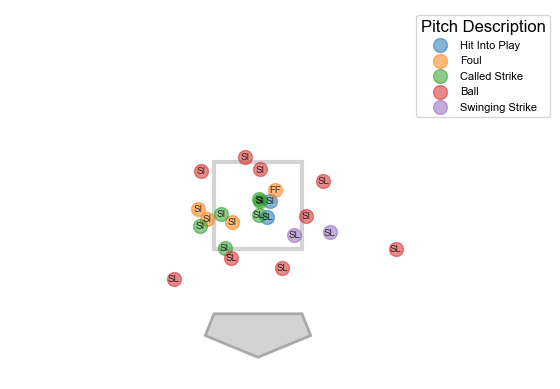

In [87]:
plot_strike_zone(all_pitches, colorby = 'description', annotation = "pitch_type")

In [26]:
points = [(0.1, 0.5), (0.2, 0.6), (0.3, 0.4), (0.4, 0.5), (0.5, 0.5), (0.9, 0.5)]

In [65]:
def animate_strike_zone(i, ax):
    ax.clear()
    
    plot_strike_zone(all_pitches, colorby = 'description', annotation = "pitch_type", animated=True, i=i, axis = ax)


In [30]:
def animate(i):
    ax.clear()
    
    # add home plate to plot 
    home_plate_coords = [[-0.71, 0], [-0.85, -0.5], [0, -1], [0.85, -0.5], [0.71, 0]]
    plate = Polygon(home_plate_coords,
                edgecolor = 'darkgray',
                facecolor = 'lightgray',
                lw = 2)
    ax.add_patch(plate)
    
    # add strike zone to plot. technically this can vary by batter
    # ignore that for now
    ax.add_patch(Rectangle((-0.71, 1.5), 2*0.71, 2,
                 edgecolor = 'lightgray',
                 fill=False,
                 lw=3))
    
    
    # Get the point from the points list at index i
    points[:i]
    
    for p in points[:i]:
        # Plot that point using the x and y coordinates
        ax.plot(p[0], p[1], color='green', 
                label='original', marker='o')
    # Set the x and y axis to display a fixed range
    ax.set_xlim(-4, 4)
    ax.set_ylim(-1.5, 7)
    
    ax.axis("off")



MovieWriter ffmpeg unavailable; using Pillow instead.


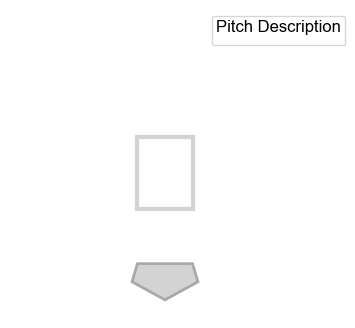

In [88]:

fig, ax = plt.subplots()
fig.set_size_inches(4, 4)
#ax.set_axis_off() # You don't actually need this line as the saved figure will not include the labels, ticks, etc, but I like to include it
#fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace = 0.5)


ani = FuncAnimation(fig, animate_strike_zone, fargs=(ax,), frames=len(all_pitches),
                    interval=500, repeat=True, repeat_delay = 1500)

# the legend is getting cut off
# Warning: discarding the 'bbox_inches' argument in 'savefig_kwargs' as it may cause frame size to vary, which is inappropriate for animation.
# I wonder if changing the loc, and bb box might help?


ani.save("strike_zone.gif", dpi=300)